In [1]:
from HySpec_Image_Processing import HDR_Image
from get_pixel_mosaic import create_arrays
from M3_UnZip import M3_unzip
import os
import matplotlib.pyplot as plt
import numpy as np
import spec_plotting
from spec_plotting import fancy_spec_plot
from spec_plotting import plot_numpy_images
from spec_average import spec_avg
from scipy import interpolate as interp
from matplotlib.animation import FuncAnimation
import cubic_spline_image
import importlib
import cubic_spline_image
importlib.reload(cubic_spline_image)
from cubic_spline_image import splineFit
from cubic_spline_image import removeNAN
import spectral as sp
from copy import copy
import tifffile as tf
import imageio
from DestripeImage import destripe

##### Getting necessary data arrays and M3 stamp list

In [2]:
if 'shadow' not in locals():
    shadow,imgStats,mosaicArray,mosaicStats = create_arrays(r'D:/Data')
    print ('Arrays Loaded')
elif 'shadow' in locals():
    print ('Arrays Exist')

hdrFileList,hdrFilesPath = M3_unzip(select=False,folder=r'D:/Data/20230209T095534013597')
stampList = []
for file in hdrFileList:
    stampList.append(HDR_Image(os.path.join(hdrFilesPath,file)))

.zip Files have already been extracted
Loading Images...


C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Images Loaded at 5.529895067214966 seconds
Getting list of shadow arrays...
2009-04-17_19-33-20_shadow.npy is already saved.
2009-05-15_04-30-23_shadow.npy is already saved.
2009-05-15_04-31-07_shadow.npy is already saved.
2009-06-05_16-32-32_shadow.npy is already saved.
2009-06-10_15-36-15_shadow.npy is already saved.
2009-06-12_10-07-53_shadow.npy is already saved.
2009-06-20_13-43-22_shadow.npy is already saved.
2009-06-24_02-43-43_shadow.npy is already saved.
2009-07-12_17-41-32_shadow.npy is already saved.
2009-07-17_04-12-42_shadow.npy is already saved.
2009-07-30_11-49-42_shadow.npy is already saved.
2009-08-12_19-51-13_shadow.npy is already saved.
2009-08-13_21-27-53_shadow.npy is already saved.
2009-08-14_06-00-13_shadow.npy is already saved.
List of shadows arrays filled at 5.96087908744812 seconds
Getting individual image statistics...
2009-04-17_19-33-20_statistics.csv is already saved.
2009-05-15_04-30-23_statistics.csv is already saved.
2009-05-15_04-31-07_statistics.csv 

C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


##### Getting average reflectance of South Pole (R<sub>bi</sub>)

In [3]:
def get_avg_rfl_data(stampList,plot_data=False):
    wvl = stampList[0].hdr.bands.centers[2:]
    rfl_avgSouthPole=np.zeros(83)
    rfl_stdSouthPole=np.zeros(83)
    for n in range(mosaicArray.shape[0]):
        rfl_avgSouthPole[n] = np.average(mosaicArray[n,:])
        rfl_stdSouthPole[n] = np.std(mosaicArray[n,:])

    
    # Plots Average Reflectance Data
    if plot_data == True:
        fig,ax = plt.subplots(1,1)
        fancy_spec_plot(fig,ax,wvl[21:73],rfl_avgSouthPole[21:73],std=rfl_stdSouthPole[21:73],
                        title="Average Reflectance of Non-Shaded Lunar South Pole",
                        ylabel= 'Reflectance', xlabel = 'Wavelength (\u03BCm)')
        
    return wvl,rfl_avgSouthPole,rfl_stdSouthPole

##### Makes shadow correction as in Li et al., 2018

Obtaining average south pole reflectance (R_bi)...
R_bi obtained
Obtaining original reflectance image (R_meas)...
R_meas Obtained
Running Li et al. Correction...


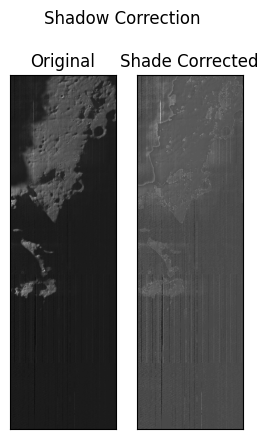

In [4]:
print ('Obtaining average south pole reflectance (R_bi)...')
wvl, rfl_avgSP, rfl_stdSP = get_avg_rfl_data(stampList, plot_data=False)
wvl = np.array(wvl)
allowedIndices = np.where((wvl>900)&(wvl<2600))[0]
allowedWvl = wvl[allowedIndices]
R_bi = rfl_avgSP[allowedIndices]
print ('R_bi obtained')

print ('Obtaining original reflectance image (R_meas)...')
hdr = sp.envi.open(r"D:/Data/20230209T095534013597/extracted_files/hdr_files/m3g20090417t193320_v01_rfl/m3g20090417t193320_v01_rfl.hdr")
R_c = hdr.read_bands(allowedIndices) # To fill in corrected values.
R_meas = hdr.read_bands(allowedIndices)
print ('R_meas Obtained')

print ('Running Li et al. Correction...')
xShade,yShade = np.where(shadow[0]==0)
xLight,yLight = np.where(shadow[0]!=0)
R_c[xShade,yShade,:] = R_c[xShade,yShade,:]/R_bi

plot_numpy_images(R_meas[:,:,0],R_c[:,:,0],titles=['Original','Shade Corrected'],
                  figtitle='Shadow Correction',figsize=(3,5),colorMap='gray')


In [5]:
import importlib
import DestripeImage
importlib.reload(DestripeImage)
from DestripeImage import destripe

R_c_destriped = destripe(R_c,7)
print (R_c_destriped.shape)
print (R_c_destriped)

Band 59 of 59 processed. (100%)

(1017, 304, 59)
[[[ 2.52099199e-01 -1.25143639e-02  6.97379667e-02 ...  8.83167482e-02
    5.20945165e-03  8.45605948e-02]
  [ 1.76397317e-01  1.25294435e-02  4.63451714e-02 ...  6.74731512e-02
    9.18619070e-03  6.42573647e-02]
  [ 1.14599744e-01  3.22828526e-02  2.78996549e-02 ...  5.05076165e-02
    1.24094848e-02  4.77837362e-02]
  ...
  [-3.03744137e-02  2.55740075e-02  1.83125397e-02 ... -8.26087863e-05
    3.41634308e-03  1.05919599e-02]
  [-7.72926705e-02  9.29595239e-03  2.78617413e-03 ... -8.08606732e-03
   -4.48208640e-03  2.78113089e-03]
  [-1.36569416e-01 -1.04859281e-02 -1.67884759e-02 ... -1.80792259e-02
   -1.43400568e-02 -7.17229307e-03]]

 [[ 1.06691594e-01  8.26683324e-03  6.82849032e-02 ...  6.58669528e-02
    4.12885755e-02  4.34300119e-02]
  [ 8.35176078e-02  1.63266089e-02  3.01017771e-02 ...  5.05474477e-02
    3.64413818e-02  3.80991924e-02]
  [ 6.38807498e-02  2.37130441e-02  1.73814187e-04 ...  3.78674914e-02
    3.21488728e-

##### Applying cubic spline correction to spectrum values

In [6]:

#plot_correction(2,2)
#plot_numpy_images(R_c_destriped[:,:,0],spectrumImage_cspl[:,:,0],titles=['Destriped','Cuibc Spline'])
#tf.imwrite(r'D:/Data/Figures/Destriped.tif',R_c_destriped[:,:,0].astype('float32'))
#tf.imwrite(r'D:/Data/Figures/CubicSpline.tif',spectrumImage_cspl[:,:,0].astype('float32'))

NameError: name 'plot_correction' is not defined

##### Plotting some pixel values

An array of size (1017, 304, 59) and band centers from 910.14μm to 2576.96μm had been loaded
(1017, 59) (1017, 59)
Averaging across x coordinate...


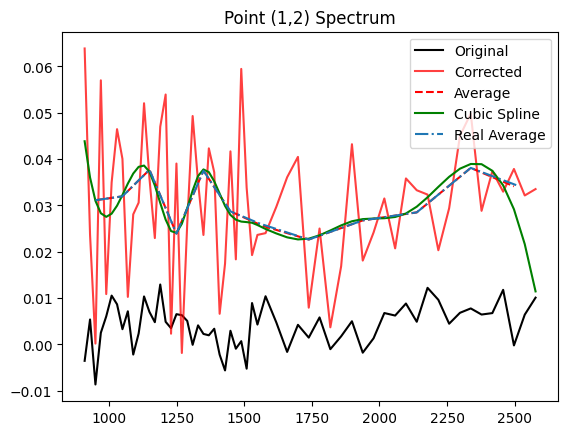

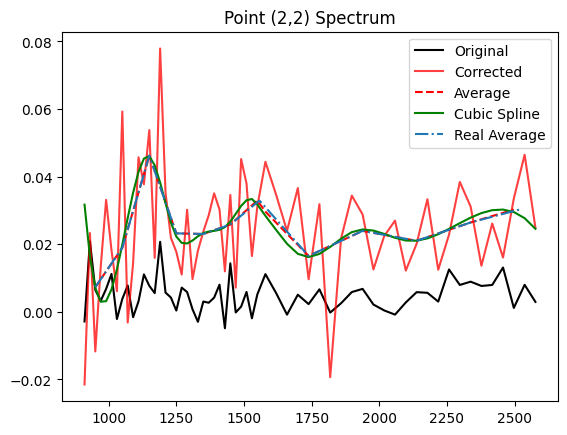

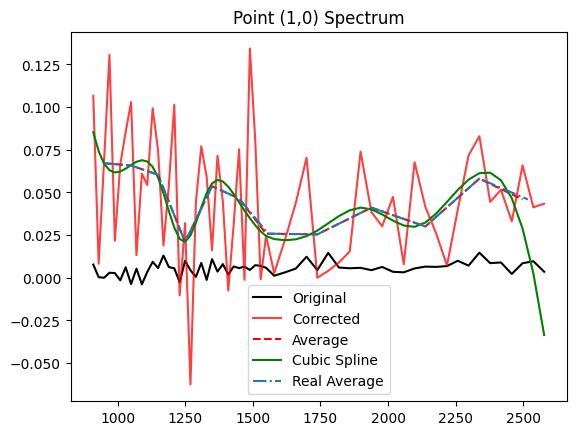

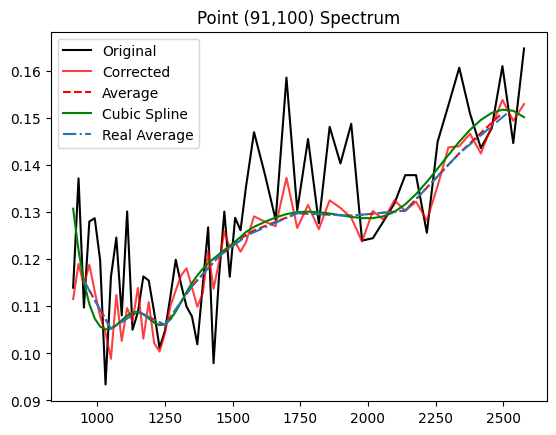

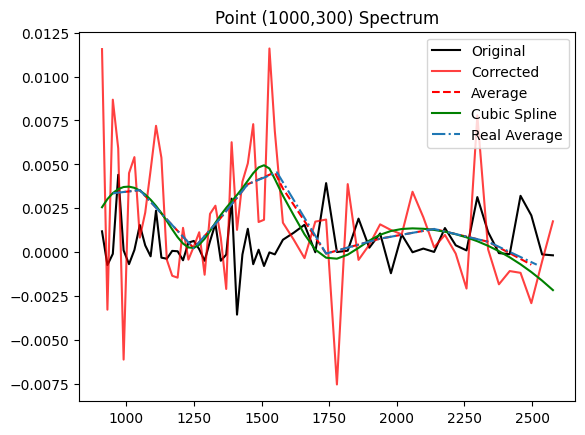

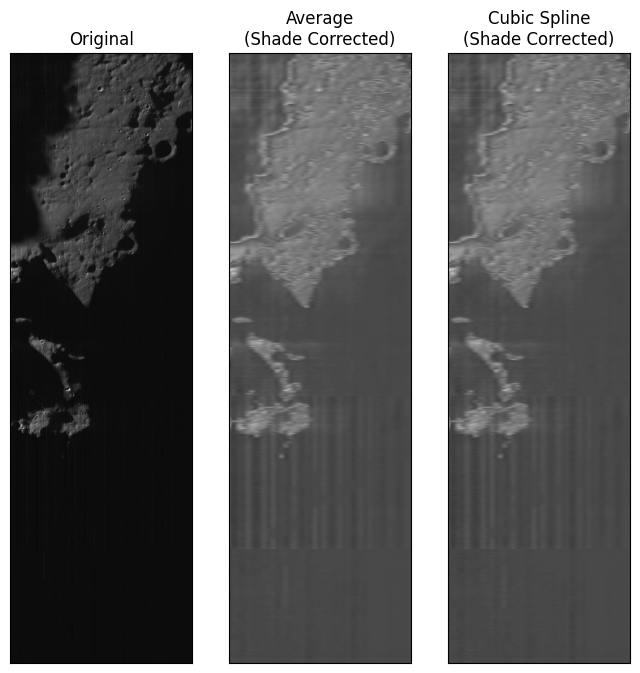

In [8]:
import cubic_spline_image
importlib.reload(cubic_spline_image)
from cubic_spline_image import splineFit
spectrumImage_avg,spectrumImage_cspl = splineFit(R_c_destriped,allowedWvl,5)

def plot_correction(x,y):
    fig,ax = plt.subplots(1,1)
    ax.plot(allowedWvl,R_meas[x,y,:],label='Original',color='k')
    ax.plot(allowedWvl,R_c_destriped[x,y,:],label='Corrected',color='red',alpha=0.75)
    ax.plot(allowedWvl,spectrumImage_avg[x,y,:],label='Average',color='red',ls='--')
    ax.plot(allowedWvl,spectrumImage_cspl[x,y,:],label='Cubic Spline',color='Green')
    ax.set_title(f'Point ({x},{y}) Spectrum')
    y,std,x = spec_avg(R_c_destriped[x,y,:],allowedWvl,5)
    ax.plot(x,y,label='Real Average',ls='-.')
    ax.legend()
plot_correction(1,2)
plot_correction(2,2)
plot_correction(1,0)
plot_correction(91,100)
plot_correction(1000,300)
    
import importlib
importlib.reload(spec_plotting)
from spec_plotting import plot_numpy_images

plot_numpy_images(R_meas[:,:,10],spectrumImage_avg[:,:,10],spectrumImage_cspl[:,:,10],
                  titles=['Original','Average\n(Shade Corrected)','Cubic Spline\n(Shade Corrected)'],colorMap='gist_gray')


In [ ]:

tf.imwrite(r'D:/Data/Figures/Avg_Band0.tif',spectrumImage_avg[:,:,10].astype('float32'))
tf.imwrite(r'D:/Data/Figures/Cubic_Band0.tif',spectrumImage_cspl[:,:,10].astype('float32'))

In [187]:
def get_minima(wvlValues:'np.ndarray',img:'np.ndarray',x:'int', y:'int',**kwargs) -> 'tuple':
    defaultKwargs = {"plotMins":False}
    kwargs = {**defaultKwargs,**kwargs}

    rflValues = img[x,y,:]

    diff_list = []
    wvlMinima = ()
    for n in range(0, len(rflValues)):
        if n < len(rflValues)-1:
            diff = rflValues[n]-rflValues[n+1]
            diff_list.append(diff)
            if n > 2 and diff < 0 and diff_list[-2] > 0:
                wvlMinima += (wvlValues[n],)
    
    ##Check if minima are indicative of water spectrum
    validWvl = np.array(([1.242,1.323],[1.503,1.659],[1.945,2.056]))
    waterBands = ()
    for val in wvlMinima:
        if any(val/1000 > i and val/1000 < j for i,j in zip(validWvl[:,0],validWvl[:,1])):
            waterBands += (val,)
        else:
            pass
    
    if kwargs.get('plotMins') == True:
        fig,ax = plt.subplots(1,1)
        ax.plot(wvlValues,rflValues,label='Cubic Spline Fit')
        for val in wvlMinima:
            ax.vlines(val,rflValues.min(),rflValues.max())

    if len(wvlMinima) == 3 and len(waterBands) == 3 and np.average(rflValues)>0.01:
        return waterBands,True,False
    elif len(wvlMinima) == 3 and len(waterBands) == 3 and np.average(rflValues)<0.01:
        return waterBands,True,True
    else:
        return wvlMinima,False,True
        #print (f'Point ({x},{y}) does not contain water ice.')

#get_minima(allowedWvl,spectrumImage_cspl,91,100)

def analyze_image(image):
    waterPixels = np.zeros([1,5]).astype(int)
    waterPixels_noise = np.zeros([1,5]).astype(int)
    xCoords,yCoords = range(int(image.shape[0])),range(int(image.shape[1]))
    xMesh,yMesh = np.meshgrid(xCoords,yCoords)

    num = 0
    for x,y in zip(xMesh.flatten(),yMesh.flatten()):
        if num < 1000000:
            print (f'\r{num+1}/{len(xMesh.flatten())} Points Processed ({num/len(xMesh.flatten()):.0%})',end='\r')
            waterBands,add,noise = get_minima(allowedWvl,image,x,y)
            if add == True and noise == False:
                waterPixels = np.concatenate([waterPixels,np.array([(x,y,*waterBands)])])
            elif add == True and noise == True:
                waterPixels_noise = np.concatenate([waterPixels_noise,np.array([(x,y,*waterBands)])])
            elif add == False:
                pass
            num+=1
        else:
            print (f'\nLoop broken at {num}')
            break
    
    #waterPixels = np.delete(waterPixels,0)
    return waterPixels,waterPixels_noise

waterPixels,waterPixels_noise = analyze_image(spectrumImage_cspl)

,,Band 1,Band 2,Band 3
x,y,,,
348.0,0.0,1289.41,1618.79,2018.02
317.0,5.0,1249.49,1528.96,1978.10
382.0,5.0,1249.49,1528.96,1978.10
305.0,6.0,1309.38,1508.99,2018.02
354.0,11.0,1249.49,1508.99,1978.10
...,...,...,...,...
170.0,300.0,1249.49,1578.86,2018.02
238.0,300.0,1249.49,1528.96,1978.10
50.0,301.0,1309.38,1528.96,1978.10


MultiIndex([( 50.0, 302.0),
            (144.0, 302.0)],
           names=['x', 'y'])

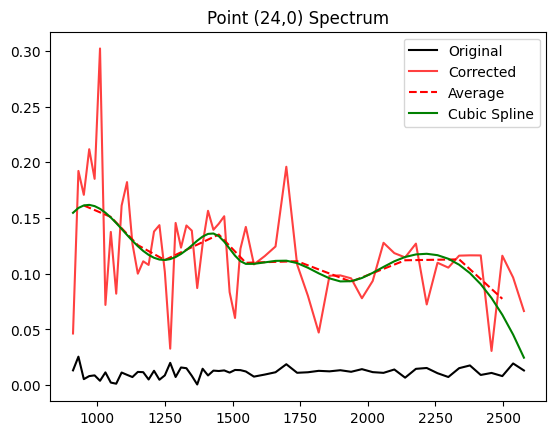

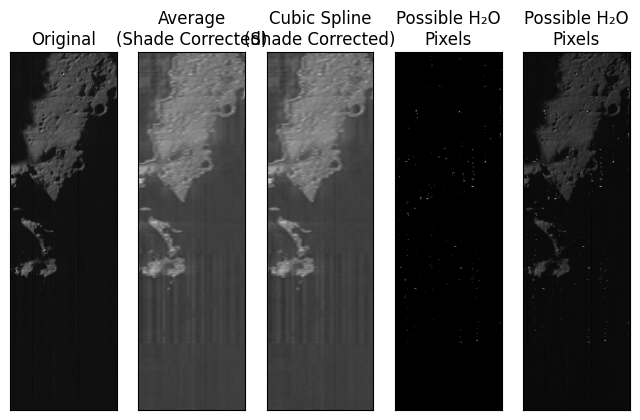

In [212]:
import pandas as pd
#print (waterPixels)
waterDf = pd.DataFrame(waterPixels)
waterDf.columns = ['x','y','Band 1','Band 2','Band 3']
waterDf.drop(waterDf.index[0],inplace=True)
waterDf.set_index(['x','y'],inplace=True)
display (waterDf)


def plot_correction_minima(x,y,**kwargs):
    defaultKwargs = {'showMinText':True}
    kwargs = {**defaultKwargs,**kwargs}

    fig,ax = plt.subplots(1,1)
    ax.plot(allowedWvl,R_meas[x,y,:],label='Original',color='k')
    ax.plot(allowedWvl,R_c_destriped[x,y,:],label='Corrected',color='red',alpha=0.75)
    ax.plot(allowedWvl,spectrumImage_avg[x,y,:],label='Average',color='red',ls='--')
    ax.plot(allowedWvl,spectrumImage_cspl[x,y,:],label='Cubic Spline',color='Green')
    if (x,y) in waterDf.index:
        wvlMin = waterDf.loc[(x,y)]
        if kwargs.get('showMinText') == True:
            for val in wvlMin:
                ax.vlines(val,spectrumImage_cspl[x,y,:].min(),spectrumImage_cspl[x,y,:].max(),ls='-.')
                ax.text(val-100,spectrumImage_cspl[x,y,:].max()+0.05*spectrumImage_cspl[x,y,:].max(),f'{val:.0f} \u03BCm')
    ax.set_title(f'Point ({x},{y}) Spectrum')
    ax.legend()


plot_correction_minima(24,0)
water_where = np.zeros(R_meas.shape)
water_where_overlaid = copy(R_meas)
water_bandDepth = copy(R_meas)
for x,y in waterDf.index:
    water_where[int(x),int(y),:] = np.ones((len(allowedWvl)))
    water_where_overlaid[int(x),int(y),:] = np.ones((len(allowedWvl)))

plot_numpy_images(R_meas[:,:,32],spectrumImage_avg[:,:,32],spectrumImage_cspl[:,:,32],water_where[:,:,32], water_where_overlaid[:,:,32],
                  titles=['Original','Average\n(Shade Corrected)','Cubic Spline\n(Shade Corrected)','Possible H\u2082O\nPixels','Possible H\u2082O\nPixels'])

x_array = np.array(waterDf.index.get_level_values(0).astype(int))
y_array = np.array(waterDf.index.get_level_values(1).astype(int))
waterDf.index[np.where(y_array==302)]

In [66]:
tf.imwrite(r'D:/Data/Figures/water_locations1.tif',water_where[:,:,32].astype('float32'))
tf.imwrite(r'D:/Data/Figures/water_locations2.tiff',water_where_overlaid[:,:,32].astype('float32'))

391 out of 18240912 contain water 0.13%
Rc: 0.00033215880368540635,R_cstar: 0.0036682843139831285


C:\Users\zacha\AppData\Local\Temp\ipykernel_24520\3959642955.py:21: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  plot_array[0] = (allowedWvl[R_short_index],allowedWvl[band1Location],allowedWvl[R_long_index])


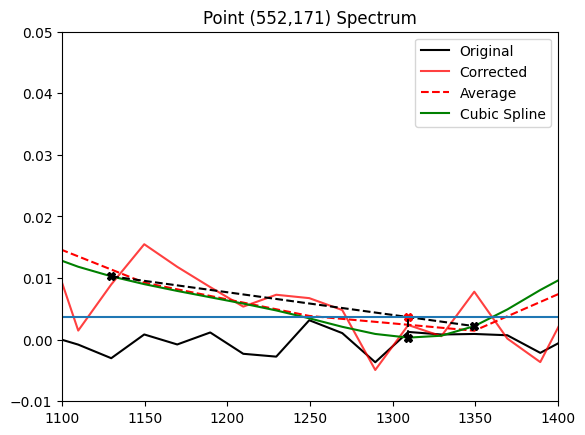

In [183]:
minLocate = np.array(([1.242,1.323],[1.503,1.659],[1.945,2.056]))
shoulderLocate = np.array(([1.13,1.35],[1.42,1.74],[1.82,2.2]))
imgSize = R_meas.shape[0]*R_meas.shape[1]
print (f'{len(waterDf.index)} out of {R_meas.size} contain water {len(waterDf.index)/imgSize:.2%}')

def band1Depth(x,y,**kwargs):
    defaultKwargs = {'plot':False}
    kwargs = {**defaultKwargs,**kwargs}

    plot_array = np.zeros((2,3))
    x,y = int(x),int(y)
    band1Value = waterDf.loc[x,y][0]
    band1Location = int(np.where(allowedWvl==band1Value)[0])
    R_short_index = np.where((allowedWvl/1000).round(2)==shoulderLocate[0][0])
    R_long_index = np.where((allowedWvl/1000).round(2)==shoulderLocate[0][1])
    R_short = spectrumImage_cspl[x,y,R_short_index][0][0]
    R_long = spectrumImage_cspl[x,y,R_long_index][0][0]
    R_center = spectrumImage_cspl[x,y,band1Location]


    plot_array[0] = (allowedWvl[R_short_index],allowedWvl[band1Location],allowedWvl[R_long_index])
    plot_array[1] = (R_short,R_center,R_long)
    b = (plot_array[0,1]-plot_array[0,0])/(plot_array[0,2]-plot_array[0,0])
    a = 1-b
    R_cstar = a*R_short+b*R_long

    m = (plot_array[1,2]-plot_array[1,0])/(plot_array[0,2]-plot_array[0,0])

    def f(xpt):
        return m*(xpt-plot_array[0,0])+plot_array[1,0]
    
    xTest = np.linspace(*plot_array[0,(0,2)],50)
    plot_correction_minima(int(x),int(y),showMinText=False)
    plt.plot(band1Value,R_center,marker='X',color='k')
    plt.plot(allowedWvl[R_short_index],R_short,marker='X',color='k')
    plt.plot(allowedWvl[R_long_index],R_long,marker='X',color='k')
    plt.plot(xTest,f(xTest),ls='--',color='k')
    plt.plot(plot_array[0,1],R_cstar,marker='X',color='red')
    plt.vlines(plot_array[0,1],R_center,f(plot_array[0,1]),ls='--',color='k')
    plt.xlim([1100,1400])
    plt.ylim([-0.01,0.05])

    if kwargs.get('plot') == False:
        plt.close()

    plt.hlines(R_cstar,0,1400)
    print (f'Rc: {R_center},R_cstar: {R_cstar}')
    return 1-abs((R_center)/(R_cstar))

band1Depth(552,171,plot=True)   

# bandDepth_array = np.zeros((len(waterDf.index),3)).astype(float)
# n=0
# for x,y in waterDf.index:
#     bandDepth = band1Depth(int(x),int(y),plot=False)
#     bandDepth_array[n] = (x,y,bandDepth)
#     n+=1

#print (bandDepth_array)
plt.plot(bandDepth_array[:,2])

[[6.60000000e+01 2.53000000e+02 6.08645177e-03]]


-0.004059500194999328

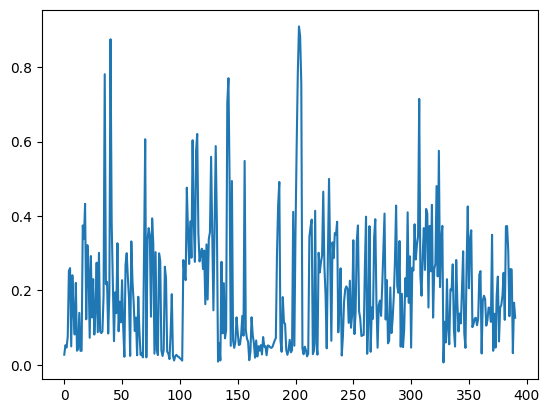

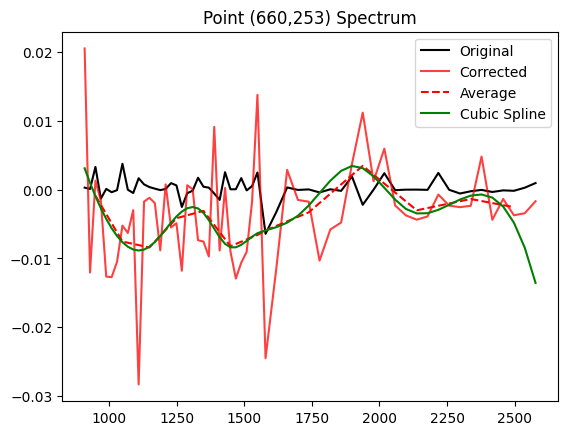

In [186]:
plt.plot(bandDepth_array[:,2])
print (bandDepth_array[np.where(bandDepth_array[:,2]==bandDepth_array[:,2].min())])
plot_correction_minima(660,253)

np.average(spectrumImage_cspl[660,253,:])